$\mathcal{D} = {(\mathbf{k}_1, \mathbf{v}_1),...,(\mathbf{k}_m, \mathbf{v}_m)}$ is the database of key-valute pairs, $\mathbf{q}$ is the query:

$
\text{Attention}(\mathbf{q}, \mathcal{D}) 
\overset{\text{def}}{=} 
\sum_{i=1}^{m} \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,
$

$\alpha(\mathbf{q}, \mathbf{k}_i)$ is the attention weight (usually computed via a similarity or alignment function).

You can pick any function $a(\mathbf{q}, \mathbf{k})$ and then defines the attention weight as a softmax-normalized similarity between the query and key:
$
\alpha(\mathbf{q}, \mathbf{k}_i) = 
\frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{
\sum_{j} \exp(a(\mathbf{q}, \mathbf{k}_j))}.
$


![attention polling](./Images/attentionPolling1.png)

In [2]:
import torch
from d2l import torch as d2l

In [11]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),cmap='Reds'):
    """Show heatmaps of matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

In [9]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights

tensor([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]])

[[<Axes: >]]


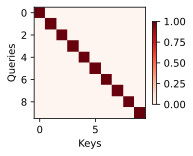

In [12]:
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

========================Attention Pooling by Similarity=========================

In [ ]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

similarity kernels from the kernel smoothing / density estimation family

1. **Gaussian kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right)
$

2. **Boxcar (Uniform) kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) =
\begin{cases}
1, & \text{if } \|\mathbf{q} - \mathbf{k}\| \le 1 \\
0, & \text{otherwise}
\end{cases}
$

3. **Epanechnikov kernel**
$
\alpha(\mathbf{q}, \mathbf{k}) = \max(0, 1 - \|\mathbf{q} - \mathbf{k}\|)
$

All the kernels  defined in this section are translation and rotation invariant; that is, if we shift and rotate $\mathbf{k}$ and $\mathbf{q}$ in the same manner, the value of $\alpha(\mathbf{q}, \mathbf{k})$ remains unchanged. For simplicity we thus pick scalar arguments $\mathbf{k}, \mathbf{q} \in \mathbb{R}^d$ and pick the key $\mathbf{k}$ = 0 as the origin. This yields:


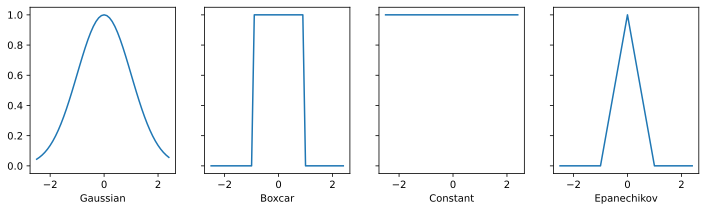

In [17]:

# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

In [24]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
# torch.rand generates uniform random numbers in [0, 1)
# torch.randn generates standard normal random numbers with mean 0 and variance 1
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

x_train, y_train, x_train.shape, y_train.shape, x_val.shape, y_val.shape

(tensor([0.0630, 0.5060, 0.5263, 0.5704, 0.6936, 0.8856, 0.9888, 1.1033, 1.1411,
         1.1667, 1.2667, 1.2686, 1.3612, 1.5092, 1.6809, 2.0090, 2.2458, 2.2764,
         2.4760, 2.6331, 2.6865, 3.0897, 3.1410, 3.3313, 3.4555, 3.5752, 3.6783,
         3.7507, 3.7683, 4.0557, 4.1563, 4.1953, 4.2018, 4.2221, 4.2987, 4.3345,
         4.6276, 4.6911, 4.7533, 4.8794]),
 tensor([-0.7819,  1.6165,  0.4712,  0.7802,  0.6549,  2.0035,  4.9155,  2.2229,
          4.6948,  2.4122,  3.7330,  2.5741,  1.5034,  4.3857,  1.9073,  5.5969,
          4.5218,  3.4873,  3.0045,  3.9304,  2.9028,  2.8961,  3.2308,  2.6530,
          0.2085,  4.1736,  1.7730,  4.1262,  0.4136,  1.5013,  2.7332,  1.4014,
          2.7071,  2.4628,  2.5055,  3.3899,  2.6864,  3.0224,  3.6191,  2.8698]),
 torch.Size([40]),
 torch.Size([40]),
 torch.Size([50]),
 torch.Size([50]))

 Attention Pooling via Nadaraya–Watson Regression

In [28]:
#  each validation feature be a query
#  each training feature–label pair be a key–value pair.
def nadaraya_watson(x_train, y_train, x_val, kernel):
    # x_train.reshape((-1, 1)): (num_train, 1)
    # x_val.reshape((1, -1)): (1, num_val)
    # dists.shape: (num_train, num_val)
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    # k.shape: (num_train, num_val)
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

torch.Size([40, 50])
torch.Size([40, 50])
torch.Size([40, 50])
torch.Size([40, 50])


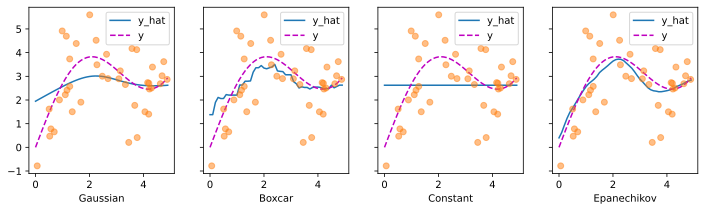

In [29]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

torch.Size([40, 50])
torch.Size([40, 50])
torch.Size([40, 50])
torch.Size([40, 50])


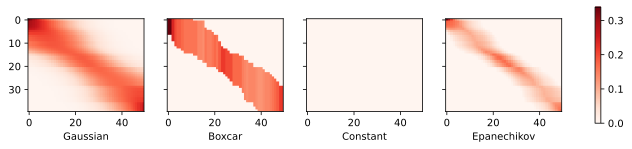

In [30]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

=============================Attention Scoring Functions=======================

![attention polling with softmax](./Images/attentionPollingSoftmax.png)

In [31]:
import math
import torch
from torch import nn
from d2l import torch as d2l

scaled dot product attention scoring function

$
a(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}.
$

$
\alpha(\mathbf{q}, \mathbf{k}_i) = \text{softmax}(a(\mathbf{q}, \mathbf{k}_i))
= \frac{\exp\left(\frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}\right)}
{\sum_{j=1}^{n} \exp\left(\frac{\mathbf{q}^\top \mathbf{k}_j}{\sqrt{d}}\right)}.
$


In [ ]:
# masked softmax operation.

from operator import add

# Note: look at last few lines, it will reshape x to 2D tensor, valid_lens to 1D tensor.
# After apply masking, it will reshape x back to original shape.

def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        print("valid_len:", valid_len)
        # dimension 1's length
        maxlen = X.size(1)

        # x[:, None] and x[None, :] add a new dimension to a tensor using `None` (equivalent to `np.newaxis`).
        # x[:, None] → Adds dimension at position 1 (after first dimension)
        # x[None, :] → Adds dimension at position 0 (before first dimension)

        mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            # Repeat the first dimension of valid_lens by shape[1] times
            valid_lens = torch.repeat_interleave(input = valid_lens, repeats = shape[1])
        else:
            # flatten to 1D tensor
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6) 
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [ ]:
# x[:, None] and x[None, :] add a new dimension to a tensor using `None` (equivalent to `np.newaxis`).
# x[:, None] → Adds dimension at position 1 (after first dimension)
# x[None, :] → Adds dimension at position 0 (before first dimension)

x = torch.rand(2, 2, 4)
y = x[:,None]
z = x[None,:]  
x, y, z, x.shape, y.shape, z.shape

(tensor([[[0.2332, 0.9304, 0.7909, 0.5200],
          [0.0860, 0.6554, 0.0429, 0.9896]],
 
         [[0.6873, 0.1354, 0.6203, 0.7330],
          [0.1660, 0.7486, 0.3618, 0.3038]]]),
 tensor([[[[0.2332, 0.9304, 0.7909, 0.5200],
           [0.0860, 0.6554, 0.0429, 0.9896]]],
 
 
         [[[0.6873, 0.1354, 0.6203, 0.7330],
           [0.1660, 0.7486, 0.3618, 0.3038]]]]),
 tensor([[[[0.2332, 0.9304, 0.7909, 0.5200],
           [0.0860, 0.6554, 0.0429, 0.9896]],
 
          [[0.6873, 0.1354, 0.6203, 0.7330],
           [0.1660, 0.7486, 0.3618, 0.3038]]]]),
 torch.Size([2, 2, 4]),
 torch.Size([2, 1, 2, 4]),
 torch.Size([1, 2, 2, 4]))

In [68]:
x = torch.rand(2, 2, 4)
x, masked_softmax(x, torch.tensor([2, 3]))

valid_len: tensor([2, 2, 3, 3])


(tensor([[[ 2.3423e-02,  2.7830e-03, -1.0000e+06, -1.0000e+06],
          [ 5.6315e-01,  3.5764e-01, -1.0000e+06, -1.0000e+06]],
 
         [[ 2.9542e-01,  5.9873e-01,  2.0726e-01, -1.0000e+06],
          [ 9.9493e-02,  2.0341e-01,  2.4212e-01, -1.0000e+06]]]),
 tensor([[[0.5052, 0.4948, 0.0000, 0.0000],
          [0.5512, 0.4488, 0.0000, 0.0000]],
 
         [[0.3058, 0.4142, 0.2800, 0.0000],
          [0.3065, 0.3400, 0.3535, 0.0000]]]))

In [69]:
# If we need more fine-grained control to specify the valid length for each of the two vectors of every example, we simply use a two-dimensional tensor of valid lengths. 

x, masked_softmax(x, torch.tensor([[1, 3], [2, 4]]))

valid_len: tensor([1, 3, 2, 4])


(tensor([[[ 2.3423e-02, -1.0000e+06, -1.0000e+06, -1.0000e+06],
          [ 5.6315e-01,  3.5764e-01, -1.0000e+06, -1.0000e+06]],
 
         [[ 2.9542e-01,  5.9873e-01, -1.0000e+06, -1.0000e+06],
          [ 9.9493e-02,  2.0341e-01,  2.4212e-01, -1.0000e+06]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5512, 0.4488, 0.0000, 0.0000]],
 
         [[0.4247, 0.5753, 0.0000, 0.0000],
          [0.3065, 0.3400, 0.3535, 0.0000]]]))

In [63]:
x, masked_softmax(x, None)

(tensor([[[ 1.0345e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
          [ 2.9721e-01,  4.0326e-03, -1.0000e+06, -1.0000e+06]],
 
         [[ 5.1894e-01,  5.9958e-01, -1.0000e+06, -1.0000e+06],
          [ 7.9539e-01,  1.9750e-01,  5.1390e-01, -1.0000e+06]]]),
 tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.5728, 0.4272, 0.0000, 0.0000]],
 
         [[0.4799, 0.5201, 0.0000, 0.0000],
          [0.4339, 0.2386, 0.3275, 0.0000]]]))

Batch Matrix Multiplication

Another commonly used operation is to multiply batches of matrices by one another. This comes in handy when we have minibatches of queries, keys, and values.
More specifically, assume that

$
\mathbf{Q} = [\mathbf{Q}_1, \mathbf{Q}_2, \ldots, \mathbf{Q}_n] \in \mathbb{R}^{n \times a \times b},
\quad
\mathbf{K} = [\mathbf{K}_1, \mathbf{K}_2, \ldots, \mathbf{K}_n] \in \mathbb{R}^{n \times b \times c}.
$

$
\mathrm{BMM}(\mathbf{Q}, \mathbf{K}) = [\mathbf{Q}_1 \mathbf{K}_1, \mathbf{Q}_2 \mathbf{K}_2, \ldots, \mathbf{Q}_n \mathbf{K}_n]
\in \mathbb{R}^{n \times a \times c}.
$


In [70]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
d2l.check_shape(torch.bmm(Q, K), (2, 3, 6))

Scaled Dot Product Attention

The scaled dot-product attention of queries
$\mathbf{Q} \in \mathbb{R}^{n \times d}$, keys $\mathbf{K} \in \mathbb{R}^{m \times d}$, and values $\mathbf{V} \in \mathbb{R}^{m \times v}$ can be written as
$\text{softmax}\left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}} \right) \mathbf{V} \in \mathbb{R}^{n \times v}$


In [71]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)


In [72]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

valid_len: tensor([2, 6])


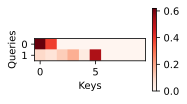

In [74]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

When queries $\mathbf{q}$ and keys $\mathbf{k}$ are vectors of different dimension, we can either use a matrix to address the mismatch via $\mathbf{q}^\top\mathbf{M}\mathbf{k}$,
 or we can use additive attention as the scoring function, Another benefit is that, as its name indicates, the attention is additive. This can lead to some minor computational savings. Given a query $\mathbf{q} \in \mathbb{R}^{q}$ and a key $\mathbf{k} \in \mathbb{R}^{k}$  the additive attention scoring function is given by:

$
a(\mathbf{q}, \mathbf{k}) = \mathbf{w}_v^\top 
\tanh\left( \mathbf{W}_q \mathbf{q} + \mathbf{W}_k \mathbf{k} \right)
\in \mathbb{R},
$
where $\mathbf{W}_q \in \mathbb{R}^{h \times q}$, $\mathbf{W}_k \in \mathbb{R}^{h \times k}$, and $\mathbf{w}_v \in \mathbb{R}^{h}$ are learnable parameters.




In [ ]:
class AdditiveAttention(nn.Module):  #@save
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # After dimension expansion, shape of queries: (batch_size, no. of queries, 1, num_hiddens)
        # shape of keys: (batch_size, 1, no. of key-value pairs, num_hiddens)
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [78]:
queries = torch.normal(0, 1, (2, 1, 20))

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))

valid_len: tensor([2, 6])


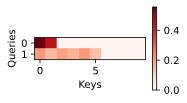

In [79]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')